# GOAL: notifications + divergence notifications
------------------------------------------------------------------------------
- Bollinger Band............. yes
- RSI........................ yes
- RSI Divergence............. no
- MACD....................... yes
- MVWAP....................... no
- RVI........................ yes
- MFI........................ no
- Min & Max lines............ yes
- Moving Averages............ no
- Candlestick Patterns....... yes
- Risk Analysis.............. no
- Earnings & Financials...... no
- News....................... yes
- Put/Call Ratio............. no
- Trending................... no
- Consolodating.............. no
- Buy Score:   Some #/#

In [2]:
#importing variables
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import matplotlib.dates as mpl_dates
import seaborn as sns
import matplotlib.pyplot as plt
import math
from openpyxl import load_workbook
# Find local peaks
from scipy.signal import argrelextrema
import yfinance as yf
import talib, time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pythoncom

In [3]:
# Function to get Bollinger Bands
def getBBands(df, period=10, stdNbr=2):
        try:
            close = df['Close']
        except Exception as ex:
            return None

        try:
            upper, middle, lower = talib.BBANDS(
                                close.values, 
                                timeperiod=period,
                                # number of non-biased standard deviations from the mean
                                nbdevup=stdNbr,
                                nbdevdn=stdNbr,
                                # Moving average type: simple moving average here
                                matype=0)
        except Exception as ex:
            return None

        data = dict(upper=upper, middle=middle, lower=lower, close=close)
        df = pd.DataFrame(data, index=df.index, columns=['upper', 'middle', 'lower','close']).dropna()

        return df 


In [4]:
# Smoothing with Wilder puts emphasis on recent values
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [5]:
# Function that indicates buy/sell signal
def buy_sell_MACD(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal['MACD'][i] > signal['signal'][i]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal["Close"][i])
                flag = 1 
            else:
                Buy.append(np.nan)
        elif signal['MACD'][i] < signal['signal'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Close'][i])
                flag = 0
                
            else:
                Sell.append(np.nan)
            
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
                
    return(Buy, Sell)

In [6]:
# Function that indicates buy/sell signal
def buy_sell_RVI(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal['RVI'][i] > signal['RVI_Signal'][i]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal["Close"][i])
                flag = 1 
            else:
                Buy.append(np.nan)
        elif signal['RVI'][i] < signal['RVI_Signal'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Close'][i])
                flag = 0
                
            else:
                Sell.append(np.nan)
            
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
                
    return(Buy, Sell)

In [7]:
# Import data for the year of ticker(s)
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []
tickers_final = ['SPY']

for i in tickers_final:
    try:
        test_data = yf.download(tickers=i, period = '1y', interval = '1d')
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
    except Exception as e:
        no_data.append(i)
        print(e)
df_copy=all_data.copy()

[*********************100%***********************]  1 of 1 completed


In [8]:
all_data.head(3)


,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2023-05-04,406.929993,407.269989,403.739990,405.130005,399.347015,94901900,SPY
2023-05-05,408.910004,413.720001,408.640015,412.630005,406.739960,87844000,SPY
2023-05-08,412.970001,413.239990,411.279999,412.739990,406.848389,50046800,SPY


In [112]:
# Makes RSI column and initializes RSI parameter variables
all_data['RSI'] = talib.RSI(all_data['Close'], timeperiod=14)
lower_barrier = 40
upper_barrier = 70
width = 5
all_data
# Sets up different dataset for finding RSI divergence
Data = all_data.copy()
Data.drop(['Volume','Adj Close','symbol'], axis=1, inplace=True)
Data.head(10)

,Open,High,Low,Close,RSI,min,max,min1,max1,min4,...,is_consolidating,consolidation_start,consolidation_start_date,consolidation_duration,duration_score,avg_volume,volume_score,consolidation_score,consolidation_score_plot,smoothed_consolidation_score
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01,418.089996,422.920013,416.790009,421.820007,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-02,424.500000,428.739990,423.950012,427.920013,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-05,428.279999,429.619995,426.369995,427.100006,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-06,426.670013,428.579987,425.989990,428.029999,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-07,428.440002,429.619995,426.109985,426.549988,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-08,426.619995,429.600006,425.820007,429.130005,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-09,429.959991,431.989990,428.869995,429.899994,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-12,430.920013,433.880005,430.170013,433.799988,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-06-13,435.320007,437.329987,434.630005,436.660004,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,NaT,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [10]:
Data['Bullish Divergence'] = ""
Data['Bearish Divergence'] = ""
bearish_below = ['']
bullish_above = ['']
# Bullish Divergence
for i in range(len(Data)):
    try:
        if Data.iloc[i, 4] < lower_barrier:
            for a in range(i + 1, i + width): 
                if Data.iloc[a, 4] > lower_barrier:
                    for r in range(a + 1, a + width):
                        if Data.iloc[r, 4] < lower_barrier and Data.iloc[r, 4] > Data.iloc[i, 4] and Data.iloc[r, 3] < Data.iloc[i, 3]:
                            for s in range(r + 1, r + width):
                                if Data.iloc[s, 4] > lower_barrier:
                                    bullish_above.append(Data.iloc[s+1,1])
                                    print('Bullish above',Data.iloc[s+1,1])
                                    Data.iloc[s + 1, 5] = 1
                                    break
                                else:
                                    continue
                        else:
                            continue
                else:
                    continue
        else:
            continue
    except IndexError as e:
        print(e)
        pass
    
        
#Bearish Divergence
for i in range(len(Data)):
    try:
        if Data.iloc[i, 4] > upper_barrier:
            for a in range(i + 1, i + width): 
                if Data.iloc[a, 4] < upper_barrier:
                    for r in range(a + 1, a + width):
                        if Data.iloc[r, 4] > upper_barrier and Data.iloc[r, 4] < Data.iloc[i, 4] and Data.iloc[r, 3] > Data.iloc[i, 3]:
                            for s in range(r + 1, r + width):
                                if Data.iloc[s, 4] < upper_barrier:
                                    bearish_below.append(Data.iloc[s+1,2])
                                    print('Bearish below',Data.iloc[s+1,2])
                                    Data.iloc[s + 1, 6] = -1
                                    break
                                else:
                                    continue
                        else:
                            continue
                else:
                    continue
        else:
            continue
    except IndexError:
        pass

Bullish above 445.2200012207031
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 452.489990234375
Bearish below 449.3500061035156
Bearish below 449.3500061035156
Bearish below 449.3500061035156
Bearish below 449.3500061035156
Bearish below 449.3500061035156
Bearish below 449.3500061035156
Bearish below 454.8699951171875
Bearish below 454.8699951171875
Bearish below 470.489990234375
Bearish below 470.489990234375
Bearish below 470.489990234375
Bearish below 470.489990234375
Bearish below 470.489990234375
Bearish below 470.489990234375
Bearish below 470.489990234375

In [11]:
bull_above = []
for i in bullish_above:
    if i not in bull_above and len(str(i)) > 0:
        bull_above.append(i)
        
bear_below = []
for i in bearish_below:
    if i not in bear_below and len(str(i)) > 0:
        bear_below.append(i)        
bull_above


[445.2200012207031]

In [12]:
# # Creates Return column
# all_data['return'] = all_data.groupby('symbol')['Close'].pct_change() 
# all_data.head(5)

In [13]:
# Fixes index problem
all_data = all_data[~all_data.index.duplicated()]

# Columns dropped for testing
# all_data.drop(index=all_data.index[:-220], axis=0, inplace=True)
# all_data.drop(index=all_data.index[-20:], axis=0, inplace=True)
all_data.tail(4)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI
Date,,,,,,,,
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,77483600,SPY,43.025953
2024-05-01,501.380005,508.190002,499.869995,500.350006,500.350006,80242800,SPY,41.515841
2024-05-02,504.149994,505.890015,499.549988,505.029999,505.029999,62550200,SPY,47.241338
2024-05-03,511.160004,512.549988,508.559998,511.290009,511.290009,72529927,SPY,53.761958


In [14]:
# Tries with high sensitivity level
n = 7
all_data['min'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']


In [15]:
# Tries with medium sensitivity level
n = 12
all_data['min1'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max1'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']

In [16]:
# Extra sensitivity level (optional)
n = 25
all_data['min4'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max4'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']
all_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,min,max,min1,max1,min4,max4
Date,,,,,,,,,,,,,,
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,46415400,SPY,51.678454,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,77483600,SPY,43.025953,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-01,501.380005,508.190002,499.869995,500.350006,500.350006,80242800,SPY,41.515841,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-02,504.149994,505.890015,499.549988,505.029999,505.029999,62550200,SPY,47.241338,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-03,511.160004,512.549988,508.559998,511.290009,511.290009,72529927,SPY,53.761958,NaN,511.290009,NaN,511.290009,NaN,NaN


In [17]:
# Draws lines for the mins and maxes - first performs shift operations
all_data['prev_min'] = all_data['min'].shift(1)
all_data['min'] = all_data.apply(lambda x : 0  if ((x['min'] == x['prev_min'])) else x['min'], axis=1)
all_data['prev_max'] = all_data['max'].shift(1)
all_data['max'] = all_data.apply(lambda x : 0  if ((x['max'] == x['prev_max'])) else x['max'], axis=1)

all_data['prev_min1'] = all_data['min1'].shift(1)
all_data['min1'] = all_data.apply(lambda x : 0  if ((x['min1'] == x['prev_min1'])) else x['min1'], axis=1)
all_data['prev_max1'] = all_data['max1'].shift(1)
all_data['max1'] = all_data.apply(lambda x : 0  if ((x['max1'] == x['prev_max1'])) else x['max1'], axis=1)

all_data['prev_min2'] = all_data['min4'].shift(1)
all_data['min4'] = all_data.apply(lambda x : 0  if ((x['min4'] == x['prev_min2'])) else x['min4'], axis=1)
all_data['prev_max2'] = all_data['max4'].shift(1)
all_data['max4'] = all_data.apply(lambda x : 0  if ((x['max4'] == x['prev_max2'])) else x['max4'], axis=1)

# n = smaller number
all_data['min2'] = all_data['min'].replace({0:np.nan})
all_data.min2 = all_data['min2'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max2'] = all_data['max'].replace({0:np.nan})
all_data.max2 = all_data['max2'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
# n = larger number
all_data['min3'] = all_data['min1'].replace({0:np.nan})
all_data.min3 = all_data['min3'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max3'] = all_data['max1'].replace({0:np.nan})
all_data.max3 = all_data['max3'].interpolate(method='spline', limit_direction='forward',order = 1, axis=0)
# n = (optional other)
all_data['min5'] = all_data['min4'].replace({0:np.nan})
all_data.min5 = all_data['min5'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max5'] = all_data['max4'].replace({0:np.nan})
all_data.max5 = all_data['max5'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)

In [18]:
# all_data['RSI_DIV'] = all_data['RSI'] / all_data['min3'] 
# all_data['RSI_DIV1'] = all_data['RSI'] / all_data['max3'] 
# all_data.tail(5)

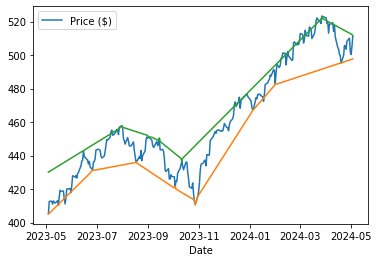

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min2)
plt.plot(all_data.max2)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

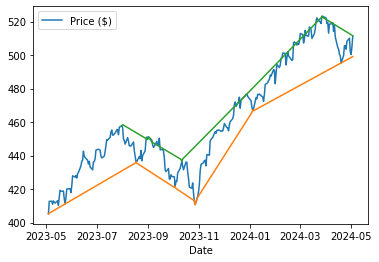

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min3)
plt.plot(all_data.max3)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

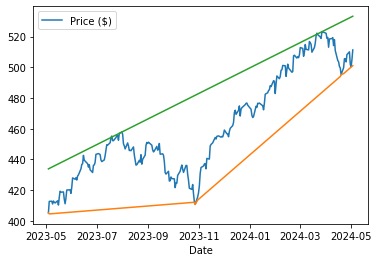

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min5)
plt.plot(all_data.max5)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

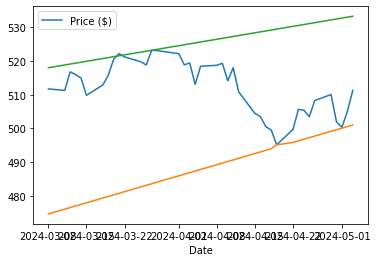

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.tail(40).Close)
# plt.plot(all_data.Close)
plt.plot(all_data.tail(40).min5)
plt.plot(all_data.tail(40).max5)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

In [23]:
# Bollinger Band function used
all_data = all_data.merge(getBBands(all_data,period=20,stdNbr=2), on = 'Date')

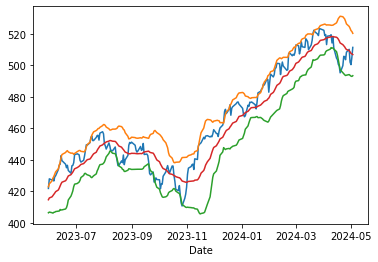

In [24]:
# Big picture
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
plt.plot(all_data.upper)
plt.plot(all_data.lower)
plt.plot(all_data.middle)
plt.xlabel('Date')

# plt.legend(['Price ($)','Max5','Min5','Max3','Min3','Max2','Min2'], loc = 'upper left')
plt.show()

In [25]:
# MACD Calculations: check if it is higher than the signal (bullish)
all_data['ShortEMA'] = all_data.Close.transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['LongEMA'] = all_data.Close.transform(lambda x: x.ewm(span=35, adjust=False).mean())
all_data['MACD'] = all_data.ShortEMA - all_data.LongEMA
all_data['signal'] = all_data.MACD.transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['macd_bullish'] = all_data.apply(lambda x : 1 if (x['MACD'] - x['signal'] > 0) else 0, axis = 1)

In [26]:
# Plotting MACD buy/sell signals
a = buy_sell_MACD(all_data)
df = all_data[['Close']]
df['Buy_Signal_Price'] = a[0]
df['Sell_Signal_Price'] = a[1]

C:\Users\amoog\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\amoog\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
# ATR and ADX are used to determine signal strength
# ATR ratio and ADX is used to figure out a true range, for volatility
all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                    np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                    abs(all_data['prev_close'] - all_data['Low'])))

for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)
all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

# Took this code from the internet for ATR AND ADX for a different project, along with the Wilder smoothing stuff
all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                        np.where((all_data['High'] > all_data['prev_high']) & 
        (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                all_data['High'] - all_data['prev_high'], 
                                                                0),np.nan)
all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                        np.where((all_data['prev_low'] > all_data['Low']) & 
        (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100
all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

# Determine if the stock has momentum and volatility (strength of the signal)
all_data['adx_signal'] = all_data.apply(lambda x : 1 if (x['ADX_15'] >= 25) else 0, axis = 1)
all_data['atr_signal'] = all_data.apply(lambda x : 1 if (x['ATR_Ratio'] >= 1) else 0, axis = 1)


In [101]:
# Calculate the range and normalize by average range over a window
all_data['range'] = all_data['max2'] - all_data['min2']
all_data['avg_range'] = all_data['range'].rolling(window=10).mean()
all_data['range_score'] = 1 - (all_data['range'] / all_data['avg_range'])

In [102]:
# Choosing threshold to start with arbitrarily, can optimize later
all_data['is_consolidating'] = all_data['range'] < (all_data['avg_range'] * 1)
# Casting 'is_consolidating' to bool to ensure compatibility
all_data['is_consolidating'] = all_data['is_consolidating'].astype(bool)

In [103]:
# Calculate duration of stability for duration scoring
all_data['consolidation_start_date'] = all_data.index.where(all_data['is_consolidating'] & (~all_data['is_consolidating'].shift(1).fillna(False)))
# Forward fill to propagate the start date of the consolidation period forward
all_data['consolidation_start_date'] = all_data['consolidation_start_date'].ffill()

In [104]:
# Calculate duration of stability
all_data['consolidation_duration'] = (all_data.index - all_data['consolidation_start_date']).dt.days # Extracts days from Timedelta
# Normalize duration score
all_data['duration_score'] = (all_data['consolidation_duration'] - all_data['consolidation_duration'].min()) / (all_data['consolidation_duration'].max() - all_data['consolidation_duration'].min())
all_data['duration_score'].fillna(0, inplace=True)  # 0 as default for non-consolidating periods

In [105]:
# Calculates volume score for different classifications
all_data['avg_volume'] = all_data['Volume'].rolling(window=10).mean()
all_data['volume_score'] = 1 - (all_data['Volume'] / (all_data['avg_volume'] + 1e-10))
all_data['volume_score'] = all_data['volume_score'].clip(lower=0)

In [106]:
# Combine scores to form a consolidated score
all_data['consolidation_score'] = (all_data['range_score'] + all_data['duration_score'] + all_data['volume_score']) / 3

In [107]:
import matplotlib.pyplot as plt
# Mask the zero values in the consolidation score
all_data['consolidation_score_plot'] = all_data['consolidation_score']
# Calculate a simple moving average of the consolidation score with a window size of 10 days
all_data['smoothed_consolidation_score'] = all_data['consolidation_score_plot'].rolling(window=10).mean()

# Normalize smoothed score to fit within the range of close prices for better visualization
min_close = all_data['Close'].min()
max_close = all_data['Close'].max()

scaled_smoothed_consolidation_score = ((all_data['smoothed_consolidation_score'] - all_data['smoothed_consolidation_score'].min()) / 
                                       (all_data['smoothed_consolidation_score'].max() - all_data['smoothed_consolidation_score'].min())) * (max_close - min_close) + min_close

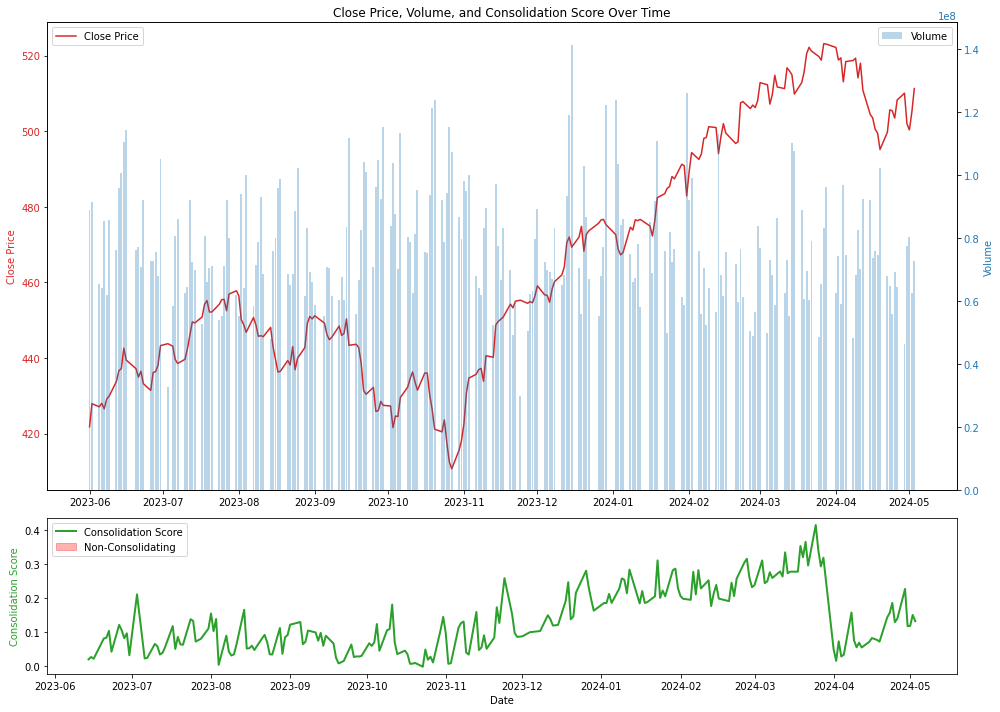

In [108]:
# Recalculate the non-consolidating condition correctly
non_consolidating = (all_data['consolidation_score'] == 0)

# Create subplots
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# Close Price and Volume on the first subplot
color = 'tab:red'
ax1.plot(all_data.index, all_data['Close'], color=color, label='Close Price')
ax1.set_ylabel('Close Price', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Secondary y-axis for Volume
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.bar(all_data.index, all_data['Volume'], color=color, alpha=0.3, label='Volume')
ax2.set_ylabel('Volume', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Consolidation score on the second subplot
color = 'tab:green'
ax3.plot(all_data.index, all_data['consolidation_score_plot'], color=color, label='Consolidation Score', linewidth=2)
ax3.set_ylabel('Consolidation Score', color=color)
ax3.set_xlabel('Date')

# Highlight non-consolidating periods
ax3.fill_between(all_data.index, 0, 1, where=non_consolidating, color='red', alpha=0.3, transform=ax3.get_xaxis_transform(), label='Non-Consolidating')

# Date formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper left')

plt.title('Close Price, Volume, and Consolidation Score Over Time')
plt.tight_layout()
plt.show()


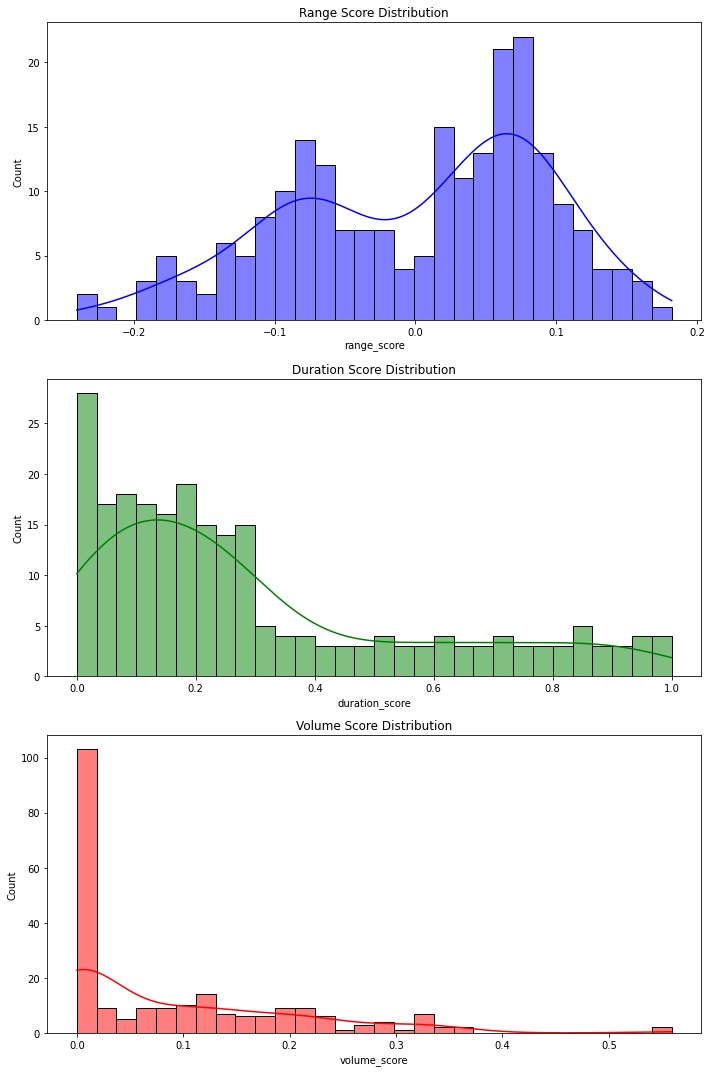

In [110]:
import seaborn as sns

# Plot distributions of component scores
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sns.histplot(all_data['range_score'], bins=30, ax=axes[0], kde=True, color='blue')
axes[0].set_title('Range Score Distribution')

sns.histplot(all_data['duration_score'], bins=30, ax=axes[1], kde=True, color='green')
axes[1].set_title('Duration Score Distribution')

sns.histplot(all_data['volume_score'], bins=30, ax=axes[2], kde=True, color='red')
axes[2].set_title('Volume Score Distribution')

plt.tight_layout()
plt.show()

In [111]:
all_data.tail()

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,min,max,...,is_consolidating,consolidation_start,consolidation_start_date,consolidation_duration,duration_score,avg_volume,volume_score,consolidation_score,consolidation_score_plot,smoothed_consolidation_score
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,46415400,SPY,51.678454,NaN,NaN,...,True,5,2024-04-01,28.0,0.190476,69443810.0,0.331612,0.228062,0.228062,0.130387
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,77483600,SPY,43.025953,NaN,NaN,...,True,5,2024-04-01,29.0,0.197279,69843770.0,0.000000,0.118441,0.118441,0.133876
2024-05-01,501.380005,508.190002,499.869995,500.350006,500.350006,80242800,SPY,41.515841,NaN,NaN,...,True,5,2024-04-01,30.0,0.204082,70277020.0,0.000000,0.119266,0.119266,0.137707
2024-05-02,504.149994,505.890015,499.549988,505.029999,505.029999,62550200,SPY,47.241338,NaN,NaN,...,True,5,2024-04-01,31.0,0.210884,69077230.0,0.094489,0.151486,0.151486,0.145048
2024-05-03,511.160004,512.549988,508.559998,511.290009,511.290009,72529927,SPY,53.761958,NaN,511.290009,...,True,5,2024-04-01,32.0,0.217687,66117312.7,0.000000,0.133226,0.133226,0.151066


In [ ]:
# Looped version (for when there are multiple tickers)
import datetime
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}
daynum = 60
tod = datetime.datetime.now()
d = datetime.timedelta(days = daynum)
a = tod - d

df_new = mid.rename_axis('Ticker').head(24)
tickers = df_new.index.tolist()

charts = []
n = 3
for ticker in tickers:
    try:
        url = finviz_url + ticker
        req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
        resp = urlopen(req)    
        html = BeautifulSoup(resp, features="lxml")
        news_table = html.find(id='news-table')
        news_tables[ticker] = news_table
        charts.append(str(url))
    except:
        pass

try:
    for ticker in tickers:
        df1 = news_tables[ticker]
        df_tr = df1.findAll('tr')
        display (df1)
        display (df_tr)
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass

# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        parsed_news.append([ticker, date, time, text])

# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

# View Data 
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    try:
        dataframe = news_dict[ticker]
        dataframe = dataframe.set_index('Ticker')
        dataframe = dataframe.drop(columns = ['Headline'])
        print ('\n')
        print (dataframe.head())
        mean = round(dataframe['compound'].mean(), 2)
        values.append(mean)
    except:
        pass

df1 = pd.DataFrame(list(zip(tickers, values, charts)), columns =['Ticker', 'Mean Sentiment', 'Chart']) 
df1 = df1.sort_values(by=['Mean Sentiment'], ascending=False)
print(df1)
# df1['Mean Sentiment'] = (df1['Mean Sentiment'] * 100) 
df1 = df1.astype({"Mean Sentiment": np.float16})
df1['Mean Sentiment'] = df1.apply(lambda x : (1 + x['Mean Sentiment']) if (x['Mean Sentiment'] >= 0) else 1 - x['Mean Sentiment'], axis = 1)
print ('\n')
print (df_new)

new = pd.merge(df_new, df1, on = 'Ticker', how = 'outer')
new = new.sort_values(by=['Mean Sentiment'], ascending=False)

print (new)
final_scores = new['Mean Sentiment'].tolist()
final_tickers = new.Ticker.tolist()
stocks = dict(zip(final_tickers, final_scores))

new.to_excel( r'C:\Users\amoog\Desktop\Stock_Notifier\Stock_Notifier\spreadsheets\{fdate}.xlsx'.format(fdate = 'Sentiment ' + tod.strftime("%d-%m-%Y")), sheet_name = 'today', index=False)
